In [1]:
#converts input image to ela applied image
from PIL import Image, ImageChops, ImageEnhance


def convert_to_ela_image(filename,quality):

    Original_Image = Image.open(filename).convert('RGB')

    Compressed_Image_filename = 'resaved_image.jpg'
    Original_Image.save(Compressed_Image_filename,'JPEG',quality=quality)
    Compressed_Image = Image.open(Compressed_Image_filename)

    ELA_Image = ImageChops.difference(Original_Image,Compressed_Image)
    
    #scaling factors are calculated from pixel extremas
    extrema = ELA_Image.getextrema()
    max_difference = max([pix[1] for pix in extrema])
    if max_difference ==0:
        max_difference = 1
    scale = 350.0 / max_difference
    
    ELA_Image = ImageEnhance.Brightness(ELA_Image).enhance(scale)

    ELA_Image.save("ela_image.png")

    return ELA_Image

In [2]:
from os import listdir
from os.path import isfile

import numpy as np

def PreProcess(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize((32,32))).flatten() / 255.0

def getDataSet(DataSetType):
    X = [] # Images
    Y = [] # 0 = fake, 1 = real

    if(DataSetType == 0):
        TestOrTrain = 'archive/train'
    else:
        TestOrTrain = 'archive/test'

    path = TestOrTrain+'/REAL'
    print(path);

    allFiles = []
    for f in listdir(path):
        if(isfile(path + '/'+ f)):
            allFiles.append(path + '/'+ f);
    
    for file in allFiles:
        if file.endswith('jpg') or file.endswith('png'):
            X.append(PreProcess(file))        
            Y.append(1)     # label for authentic images 
            
    print(f'Total images: {len(X)}\nTotal labels: {len(Y)}')


    path = TestOrTrain+'/FAKE'
    print(path);

    allFiles = []
    for f in listdir(path):
        if(isfile(path + '/'+ f)):
            allFiles.append(path + '/'+ f);
    
    for file in allFiles:
        if file.endswith('jpg') or file.endswith('png'):
            X.append(PreProcess(file))        
            Y.append(0)     # label for authentic images 
            
    print(f'Total images: {len(X)}\nTotal labels: {len(Y)}')

    X = np.array(X)
    Y = np.array(Y)
    X = X.reshape(-1, 32, 32, 3)

    return X, Y

In [3]:

import tensorflow as tf

# Display the version
print(tf.__version__)

# other imports
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input,Activation,Conv2D, Conv2DTranspose, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from tensorflow.keras import layers
from tensorflow.python.keras.utils.np_utils import to_categorical
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

2.10.0


In [20]:
test_X, test_Y = getDataSet(1);

archive/test/REAL
Total images: 10000
Total labels: 10000
archive/test/FAKE
Total images: 20000
Total labels: 20000


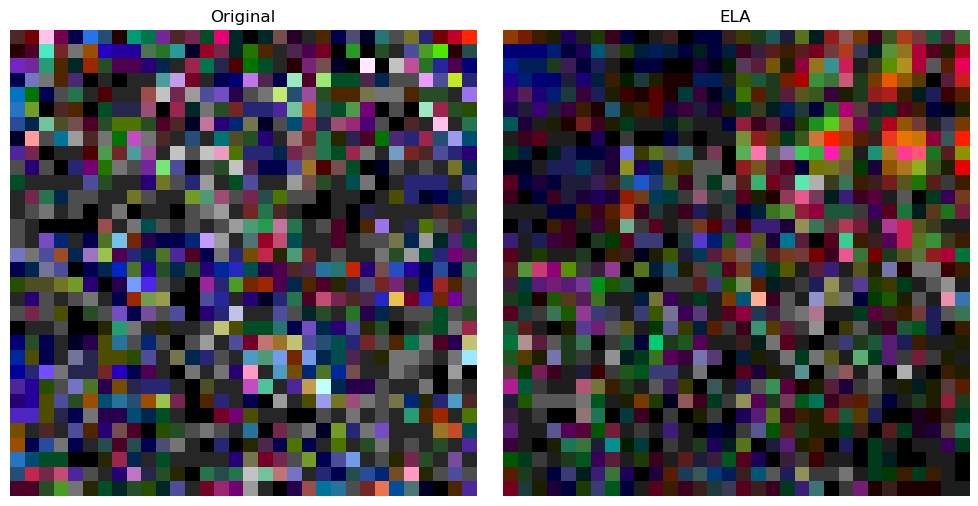

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(test_X[0])
axes[0].set_title('Original')
axes[0].axis('off')

# Display the ELA image
axes[1].imshow(test_X[1])
axes[1].set_title('ELA')
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [8]:
np.save( "testDatasetX.npy",test_X)
np.save("testDatasetY.npy",test_Y)



In [10]:

model = Sequential()

model.add(Input(shape=(32, 32, 3)))

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='valid', strides=(1, 1)))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='valid', strides=(1, 1)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='valid', strides=(1, 1)))


model.add(Conv2DTranspose(filters=64, kernel_size=(3, 3), activation='relu', padding='valid', strides=(1, 1)))
model.add(Conv2DTranspose(filters=32, kernel_size=(3, 3), activation='relu', padding='valid', strides=(1, 1)))


model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 64)        18496     
                                                                 
 conv2d_transpose (Conv2DTra  (None, 28, 28, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 30, 30, 32)       18464     
 ranspose)                                                       
                                                                 
 flatten (Flatten)           (None, 28800)             0

In [11]:

r = model.fit(train_X, train_Y , epochs=10, batch_size=256,validation_data=(test_X, test_Y))

Epoch 1/10
50/50 [==============================] - 9s 180ms/step - loss: 0.6184 - accuracy: 0.6611 - val_loss: 0.5490 - val_accuracy: 0.7306
Epoch 2/10
50/50 [==============================] - 8s 165ms/step - loss: 0.5229 - accuracy: 0.7435 - val_loss: 0.5351 - val_accuracy: 0.7316
Epoch 3/10
50/50 [==============================] - 9s 177ms/step - loss: 0.4944 - accuracy: 0.7595 - val_loss: 0.4768 - val_accuracy: 0.7753
Epoch 4/10
50/50 [==============================] - 9s 174ms/step - loss: 0.4721 - accuracy: 0.7767 - val_loss: 0.4700 - val_accuracy: 0.7788
Epoch 5/10
50/50 [==============================] - 9s 176ms/step - loss: 0.4634 - accuracy: 0.7832 - val_loss: 0.4710 - val_accuracy: 0.7856
Epoch 6/10
50/50 [==============================] - 9s 174ms/step - loss: 0.4455 - accuracy: 0.7937 - val_loss: 0.4454 - val_accuracy: 0.7972
Epoch 7/10
50/50 [==============================] - 9s 171ms/step - loss: 0.4237 - accuracy: 0.8059 - val_loss: 0.4335 - val_accuracy: 0.8009
Epoch 

In [12]:
model.save('my_model.keras')

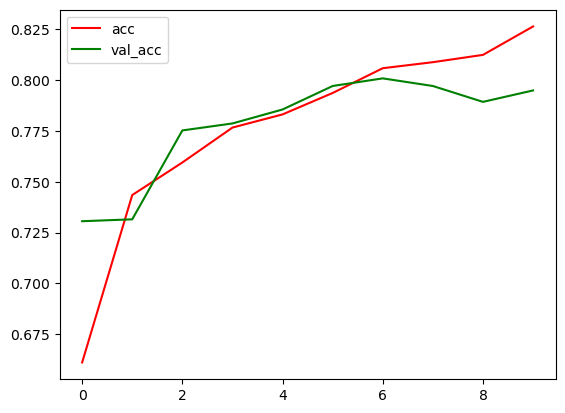

In [13]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc', color='red')
plt.plot(r.history['val_accuracy'], label='val_acc', color='green')
plt.legend()
#pd.DataFrame(history.history).plot()

In [14]:
new_model = tf.keras.models.load_model('my_model.keras')

# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 64)        18496     
                                                                 
 conv2d_transpose (Conv2DTra  (None, 28, 28, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 30, 30, 32)       18464     
 ranspose)                                                       
                                                                 
 flatten (Flatten)           (None, 28800)             0

Name of image to run?
 Cat.jpg


1/1 [==============================] - 0s 17ms/step


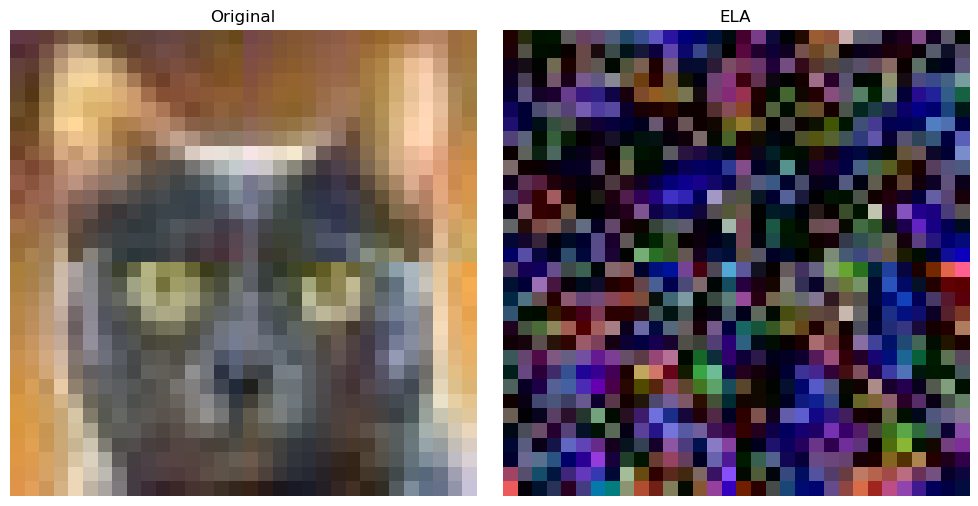

Prediction: [[0. 1.]]


In [21]:
import matplotlib.image as mpimg

imageName = input('Name of image to run?\n')

test_case = convert_to_ela_image(imageName,90)
test_case.save("ELA.jpg",'JPEG')
test_case = np.reshape(test_case, (1, 32, 32, 3))
prediction = new_model.predict(test_case)


original_image = mpimg.imread(imageName)
ela_image = mpimg.imread("ELA.jpg")

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_image)
axes[0].set_title('Original')
axes[0].axis('off')
# Display the ELA image
axes[1].imshow(ela_image)
axes[1].set_title('ELA')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("Prediction:", prediction)